# о трансдьюсерах

Подробное чтение есть во 2 издании [Jurafsky and Martin](http://idiom.ucsd.edu/~bakovic/compphon/Jurafsky,%20Martin.-Speech%20and%20Language%20Processing_%20An%20Introduction%20to%20Natural%20Language%20Processing%20(2007).pdf) (глава 3 и раздел 11.2)

И много статей на aclweb.org

---

Существуют трансдьюсеры. 
Они как конечные автоматы (а те -- как регулярные выражения), но умеют генерировать какой-то текст.

Идея за использованием трансдьюсеров для порождения текстов в ответ на тексты такая: неоднозначные соответствия обычно разрешаются из контекстного знания.

Например, `h` транслитерируется в `ш` только если перед ней была `s`, причём `s` в таком случае не должна была превратиться в `c`.

Давайте заведём два состояния: 
0. "мы видим букву и перед ней мы видели букву s" и 
1. "все остальные случаи"



Если от лени свести английский язык к буквам `abfsh`, то вышерассказанныя транслитерация иллюстрируется так. Слева от двоеточия -- символ, по которому мы переходим в трансдьюсере, как в автомате. А что за дополнительная строка справа -- читайте ниже :)



<img src="img/transducer.jpg" height="300"/>

Используется трансдьюсер так:
в начале у меня есть строка и трансдьюсер. Я буду применять трансдьюсер к строке.

---

В начале я нахожусь в начальном состоянии трансдьюсера. и смотрю на нулевую букву слова.

Если из моего состояния исходит стрелка в другое состояние, подписанная такой же буквой, как нулевая буква моего слова, то я оказываюсь в том другом состоянии и смотрю уже на следующую букву слова.

Если из моего состояния исходит стрелка в другое состояние, подписанная эпсилоном, то я оказываюсь в том другом состоянии, но смотрю всё ещё на текущую букву слова.

И так каждый раз.  
В каждый момент времени я могу находиться в нескольких состояниях и совершаю все доступные переходы по ним.

---

Если в какой-то момент закончилась строка, то: если среди состояний в которых я нахожусь, есть финальное, то трансдьюсер сработал успешно и мне интересен путь, который я по нему прошёл до финального состояния.

---

На пути, который я прошёл по трансдьюсеру до финального состояния, были стрелки. Стрелки были подписаны какими-то символами или эпсилонами. А ещё каждой стрелке был сопоставлен ещё один символ (а может даже строка!).  

Это читается так: придя в какое-то состояние, я принёс с собой некоторую строку (в нулевом состоянии она была -- пустой). Переходя по стрелке, я дописываю к этой некоторой строке то дополнительное, которое было тоже надписано на стрелке. Так, дойдя до финального состояния, я принесу в него некоторую строку, которая получилась применением трансдьюсера к оригинальной строке.

Ниже -- использование библиотеки Helsinki Final State Technology для того, чтобы построить и использовать трансдьюсер, описанный выше. Это богатая библиотека и на ней получается построить многоогромные трансдьюсеры, автоматически глоссирующие тексты многих языков. Что-то такое рассказывал Ник.

У hfst (и почему-то всех других библиотек про трансдьюсеры) есть проблемы с установкой на винду, поэтому можно, вот, в колабе.

### создание трансдьюсера

In [ ]:
!python3 -m pip install hfst

     |████████████████████████████████| 26.9MB 166kB/s 


In [2]:
import hfst

# создание трансдьюсера

t = hfst.HfstBasicTransducer()

# описываем трансдьюсер связями: 
# <исходное состояние, 
#  результирующее состояние, 
#  символ, по которому можно перейти по этой связи, 
#  текст, который нужно породить, проходя по этой связи>
t.add_transition(0, 0, 'a', 'а')
t.add_transition(0, 0, 'b', 'б')
t.add_transition(0, 0, 'f', 'ф')
t.add_transition(0, 0, 'h', 'х')
t.add_transition(0, 1, 's', hfst.EPSILON)  # эписилон и тут альтернатива пустой строке ('')
t.add_transition(1, 0, 'h', "ш")
t.add_transition(1, 0, 'a', 'са')
t.add_transition(1, 0, 'b', 'сб')
t.add_transition(1, 0, 'f', 'сф')

t.add_transition(1, 2, hfst.EPSILON, 'с')  # подумайте, зачем эта строка

# в hfst принято присваивать финальным вершинам веса (что-то типа вероятности)
# нам это не нужно, но это самый простой способ пометить вершину как конечную
t.set_final_weight(0, 1)
t.set_final_weight(2, 1)

### рисование трансдьюсера

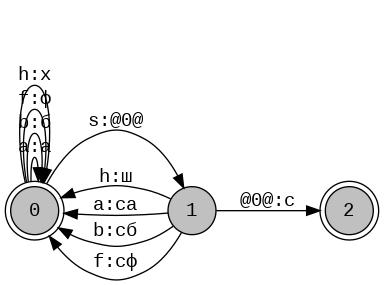

In [17]:
# можно нарисовать граф. для записи графов часто используется язык dot
# конвертируем наш трансдьюсер в dot-файл

# код визуализации стащен у Франа Тайерза и чуть модифицирован 
# (https://ftyers.github.io/2017-КЛ_МКЛ/hfst.html)

with open("my_cool_transducer.dot", 'w') as transducer_f:
    print('digraph G { rankdir="LR"', file=transducer_f)
    print('node [fontname="Tahoma",shape=circle,fontsize=14,fixedsize=true,fillcolor="grey",style=filled]', file=transducer_f)
    print('edge [fontname="FreeMono",fontsize=14]', file=transducer_f)
    for line in str(t).splitlines():
        line = line.strip()
        row = line.split('\t')
        if len(row) >= 4:
            print(f"{row[0]} [label=\"{row[0]}\"];", file=transducer_f)
            print(f"{row[0]} -> {row[1]} [label=\"{row[2]}:{row[3]}\"];", file=transducer_f)
        elif len(row) == 2: # Final state
            print(f"{row[0]} [label=\"{row[0]}\",shape=doublecircle];", file=transducer_f)
    print('}', file=transducer_f)

!dot -Tjpg my_cool_transducer.dot > my_cool_transducer.jpg
from IPython.display import Image
Image(filename='my_cool_transducer.jpg') 

### использование трансдьюсера

In [60]:
from collections import defaultdict

def transduce(w):

    trans_di_no_eps = defaultdict(list)
    # lookup слова в трансдьюсере отвечает списком строк, 
    # которые получились при путешествии по трансдьюсеру с нашим словом
    # и их вероятностей. вероятности нам сейчас вроде не нужны
    for k, vals in t.lookup(w).items():
        # единственное, каждый раз, работая с эпсилоном, hfst запоминал это
        # поэтому в процессе работы получаются всякие строки с кучей слов EPSILON 
        # в середине. это само по себе может быть полезно для восстановления истории
        # но мы вроде не про это.
        # поэтому реплейс
        pretty_k = k.replace(hfst.EPSILON, '')
        for v, v_proba in vals:
            pretty_v = v.replace(hfst.EPSILON, '')
            trans_di_no_eps[pretty_k].append((pretty_v, v_proba))
        
    # вообще у нас не просто список получившихся строк, а
    # словарь, в котором обычно единственный ключ -- наше исходное слово
    # а значение -- тот самый список получившихся строк.
    transduced = trans_di_no_eps.get(w, [(None, 1.0)])


    if len(transduced) != 1:
        # иногда могут получиться несколько альтернативных строк. 
        # в мире трансдьюсеров это ок, но мы такого не ждём
        print(f"wow smth strange happened for word {w}: ", transduced)
    
    # для простоты запомним только первый вариант, даже если их несколько
    transduction_res = transduced[0][0]
    return transduction_res


for w in ["bas", "bah", "bash", "bashs"]:
    print(transduce(w))

бас
бах
баш
башс


## о чём лаба?

Лаба состоит в том, чтобы уметь прочитать трансдьюсер и либо воспользоваться им для транслитерации, либо -- для поиска.

Формат записи, предложенный в лабе, соблюдать не обязательно: используйте тот способ задать трансдьюсер, который вам подходит.

Использовать hfst и другие трансдьюсерные библиотеки в итоговом коде не стоит: можно полагаться на них для самопроверки, но постарайтесь реализовать переходы по графу с поддержанием состояний самостоятельно.

Если совсем грустно, пишите! Я больше не планирую пропадать на неделю.